In [13]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Queenstown'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]
from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 7327


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129006,QUEENSTOWN,3 ROOM,83,C'WEALTH CL,60.0,Standard,1967,43 years 08 months,328000.0,11.0,65.0
129007,QUEENSTOWN,3 ROOM,97,C'WEALTH CRES,59.0,Standard,1970,47 years 01 month,293000.0,2.0,65.0
129008,QUEENSTOWN,3 ROOM,99,C'WEALTH CRES,55.0,Standard,1970,47 years 01 month,300000.0,2.0,65.0
129009,QUEENSTOWN,3 ROOM,51,C'WEALTH DR,63.0,Model A,2015,91 years 09 months,598000.0,11.0,65.0
129010,QUEENSTOWN,3 ROOM,28B,DOVER CRES,69.0,Model A,2012,88 years 10 months,585000.0,38.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153362,QUEENSTOWN,4 ROOM,91,TANGLIN HALT RD,90.0,Model A,2008,84 years 03 months,932000.0,41.0,76.0
153363,QUEENSTOWN,5 ROOM,7A,C'WEALTH AVE,138.0,Model A,1996,72 years 05 months,1200000.0,11.0,76.0
153364,QUEENSTOWN,5 ROOM,26,DOVER CRES,123.0,Standard,1978,53 years 09 months,780000.0,11.0,76.0
153365,QUEENSTOWN,5 ROOM,20,HOLLAND DR,117.0,Standard,1975,50 years 08 months,880800.0,14.0,76.0


In [3]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 7173
0 of 155
10 of 155
20 of 155
30 of 155
40 of 155
50 of 155
60 of 155
70 of 155
80 of 155
90 of 155
100 of 155
110 of 155
120 of 155
130 of 155
140 of 155
150 of 155
0 errors detected
pickle dumped. 7328


In [82]:
#df[(df.street_name=='JLN BATU')|(df.street_name=='JLN BAHAGIA')|(df.street_name=='JLN TENTERAM')|(df.street_name=='')]
#df.describe()

#df[df.lat>1.32]
#df[df.street_name.str.startswith("C'WEALTH")].lat.min()
df[df.lat==df.lat.max()]
#longLats["50 C'WEALTH DR"]
#np.where(blk_street.unique()==("50 C'WEALTH DR"))
#responses[19]


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date,long,lat
129027,QUEENSTOWN,4 ROOM,53,C'WEALTH DR,93.0,Model A,2015,91 years 08 months,830000.0,11.0,65.0,103.66578,1.31675
138227,QUEENSTOWN,3 ROOM,53,C'WEALTH DR,63.0,Model A,2015,91 years 05 months,648000.0,14.0,69.0,103.66578,1.31675
138252,QUEENSTOWN,4 ROOM,53,C'WEALTH DR,88.0,Model A,2015,91 years 05 months,892000.0,29.0,69.0,103.66578,1.31675
140256,QUEENSTOWN,3 ROOM,53,C'WEALTH DR,63.0,Model A,2015,91 years 04 months,642000.0,29.0,70.0,103.66578,1.31675
140304,QUEENSTOWN,5 ROOM,53,C'WEALTH DR,117.0,Improved,2015,91 years 04 months,1170000.0,11.0,70.0,103.66578,1.31675
151396,QUEENSTOWN,3 ROOM,53,C'WEALTH DR,63.0,Model A,2015,90 years 11 months,645000.0,14.0,75.0,103.66578,1.31675
151411,QUEENSTOWN,4 ROOM,53,C'WEALTH DR,88.0,Model A,2015,90 years 11 months,815000.0,5.0,75.0,103.66578,1.31675
151412,QUEENSTOWN,4 ROOM,53,C'WEALTH DR,88.0,Model A,2015,90 years 11 months,827000.0,14.0,75.0,103.66578,1.31675
151413,QUEENSTOWN,4 ROOM,53,C'WEALTH DR,88.0,Model A,2015,90 years 10 months,745000.0,2.0,75.0,103.66578,1.31675
153330,QUEENSTOWN,3 ROOM,53,C'WEALTH DR,63.0,Model A,2015,90 years 10 months,655288.0,23.0,76.0,103.66578,1.31675


In [83]:
del longLats["53 C'WEALTH DR"]
dump_pkl(longLats)

pickle dumped. 7307


In [84]:
import math

def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x] if x in longLats else (math.nan, math.nan))
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()



,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,645.000000,645.000000,6.450000e+02,645.000000,645.000000,634.000000,634.000000
mean,84.206202,1996.474419,6.939971e+05,15.353488,70.097674,103.796123,1.302669
std,19.407592,19.610605,2.492083e+05,10.914220,3.363313,0.010365,0.007453
min,45.000000,1967.000000,2.500000e+05,2.000000,65.000000,103.781343,1.289098
25%,67.000000,1975.000000,4.300000e+05,8.000000,67.000000,103.785072,1.294752
50%,86.000000,2003.000000,7.300000e+05,11.000000,70.000000,103.795478,1.306194
75%,93.000000,2016.000000,8.920000e+05,23.000000,73.000000,103.804342,1.309228
max,156.000000,2018.000000,1.418000e+06,47.000000,76.000000,103.815025,1.313065


In [86]:
#df = pd.read_csv('./data/Kallang_Whampoa_June22_May23.csv')
df = df[~df.long.isna()].copy()
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date,long,lat
129006,QUEENSTOWN,3 ROOM,83,C'WEALTH CL,60.0,Standard,1967,43 years 08 months,328000.0,11.0,65.0,103.800422,1.304690
129009,QUEENSTOWN,3 ROOM,51,C'WEALTH DR,63.0,Model A,2015,91 years 09 months,598000.0,11.0,65.0,103.804707,1.298864
129010,QUEENSTOWN,3 ROOM,28B,DOVER CRES,69.0,Model A,2012,88 years 10 months,585000.0,38.0,65.0,103.782499,1.306194
129011,QUEENSTOWN,3 ROOM,3,DOVER RD,65.0,Improved,1975,52 years 02 months,358000.0,11.0,65.0,103.782909,1.303671
129012,QUEENSTOWN,3 ROOM,32,GHIM MOH LINK,68.0,Model A,2018,95 years 01 month,718000.0,29.0,65.0,103.784492,1.310042
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153361,QUEENSTOWN,4 ROOM,89,TANGLIN HALT RD,90.0,Model A,2008,84 years 04 months,860000.0,32.0,76.0,103.798939,1.301214
153362,QUEENSTOWN,4 ROOM,91,TANGLIN HALT RD,90.0,Model A,2008,84 years 03 months,932000.0,41.0,76.0,103.799300,1.301128
153364,QUEENSTOWN,5 ROOM,26,DOVER CRES,123.0,Standard,1978,53 years 09 months,780000.0,11.0,76.0,103.781586,1.305889
153365,QUEENSTOWN,5 ROOM,20,HOLLAND DR,117.0,Standard,1975,50 years 08 months,880800.0,14.0,76.0,103.792269,1.310494


In [52]:
df.describe()
df[df.long==103.844827]

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date,long,lat
601,KALLANG/WHAMPOA,5 ROOM,103,AH HOOD RD,118.0,Improved,1981,57 years 08 months,805000.0,20.0,72.0,103.844827,1.327964
721,KALLANG/WHAMPOA,5 ROOM,103,AH HOOD RD,118.0,Improved,1981,57 years 06 months,805000.0,17.0,74.0,103.844827,1.327964


In [39]:
longLats = load_pkl()
longLats['12 KG ARANG RD'] = (103.883695,1.300833)
longLats['77 LOR LIMAU'] = (103.854796,1.325164)
dump_pkl(longLats)

longLats loaded. 6349
pickle dumped. 6349


SuggestedLRs(valley=0.0012022644514217973, slide=6.309573450380412e-07)

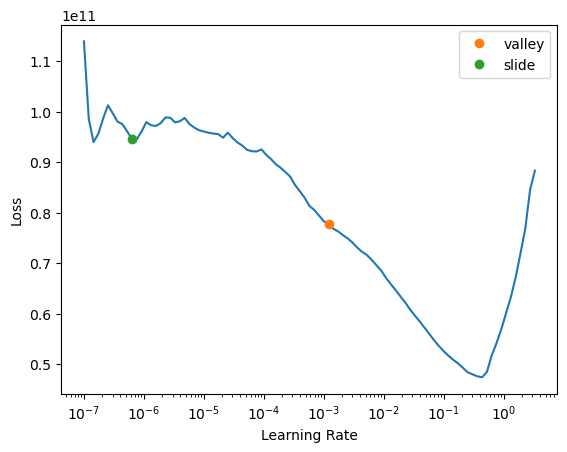

In [69]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [92]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 54087.20703125.


(#2) [2952809216.0,54087.20703125]

In [93]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 4*35
n2 = 2*35
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()
print('done!')

0 of 70
10 of 70
20 of 70
30 of 70
40 of 70
50 of 70
60 of 70
done!


In [78]:
import http.client, urllib.parse
import json

mrts = ["Holland Village MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 7307
Holland Village Stn/Blk 12, Singapore, confidence 1
pickle dumped. 7308


In [77]:
longLats["Holland Village MRT"]

KeyError: 'Holland Village MRT'

In [54]:
longLats['Kallang MRT'] = (103.87142, 1.31117)
dump_pkl(longLats)

pickle dumped. 6351


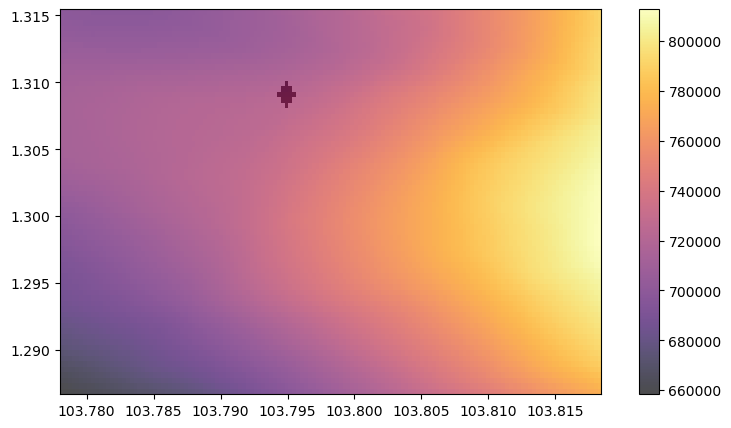

In [96]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

mrts = ["Holland Village MRT"]
map_star(*min_coords(*longLats[mrts[0]]))
#map_star(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))
#map_star(*min_coords(*longLats[mrts[5]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

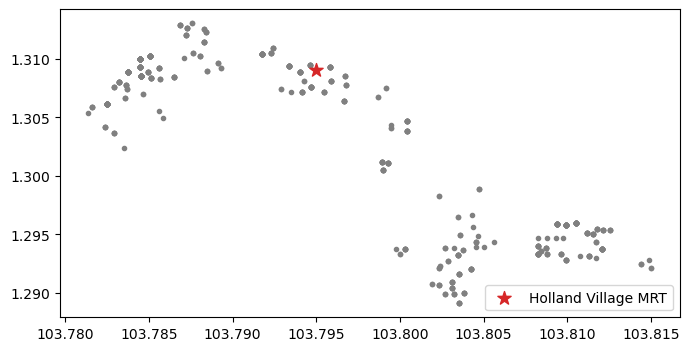

In [94]:
circle = "#FA9E0D"
ew = "#009645"
dt = "#005EC4"
red = '#d62728'
ne = '#9900AA'
markers = ["*", '*', "<", '<', '<', '*', '^']
colors = [red,ew,ew,ew,ew,red]
mrts = ["Holland Village MRT"]
fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.',c="gray")
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c=colors[i],label=mrt,s=100)
ax2.legend(loc='lower right')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
